<a href="https://colab.research.google.com/github/chayakim/Data_Analytics/blob/main/Final_Hours_of_XGBOOTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
try:
    import ace_tools as tools
except ModuleNotFoundError:
    print("The 'ace_tools' module is not installed. Please install it using pip:")
    print("!pip install ace_tools")
    def display_dataframe_to_user(name, dataframe):
        print(f"--- {name} ---")
        print(dataframe.head())
        print(f"--- End of {name} ---")
    tools = type('', (), {'display_dataframe_to_user': display_dataframe_to_user})

The 'ace_tools' module is not installed. Please install it using pip:
!pip install ace_tools


In [ ]:
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

energy_df['time'] = pd.to_datetime(energy_df['time'], errors='coerce', utc=True)
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], errors='coerce', utc=True)

energy_df['time'] = energy_df['time'].dt.tz_localize(None)
weather_df['dt_iso'] = weather_df['dt_iso'].dt.tz_localize(None)

merged_df = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso', how='inner')

merged_df.drop(columns=['dt_iso', 'city_name'], inplace=True)

merged_df.fillna(method='ffill', inplace=True)

merged_df['hour'] = merged_df['time'].dt.hour
merged_df['day_of_week'] = merged_df['time'].dt.dayofweek
merged_df['month'] = merged_df['time'].dt.month
merged_df['year'] = merged_df['time'].dt.year

weather_features = merged_df[['temp', 'wind_speed', 'humidity', 'pressure','clouds_all']]
scaler = StandardScaler()
weather_features_scaled = scaler.fit_transform(weather_features)

kmeans = KMeans(n_clusters=5, random_state=42)
merged_df['weather_cluster'] = kmeans.fit_predict(weather_features_scaled)

XGBOOST_features = [
    'time', 'temp', 'wind_speed', 'humidity', 'pressure',
    'hour', 'day_of_week', 'month', 'weather_cluster',
    'total load actual','clouds_all']

XGBOOST_data = merged_df[XGBOOST_features]


<ipython-input-2-6f2de2b1a62f>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


MAE: 1809.491929236442
RMSE: 2541.3789902653148
R^2: 0.6928700790196147
MAPE: 6.425351981476951%


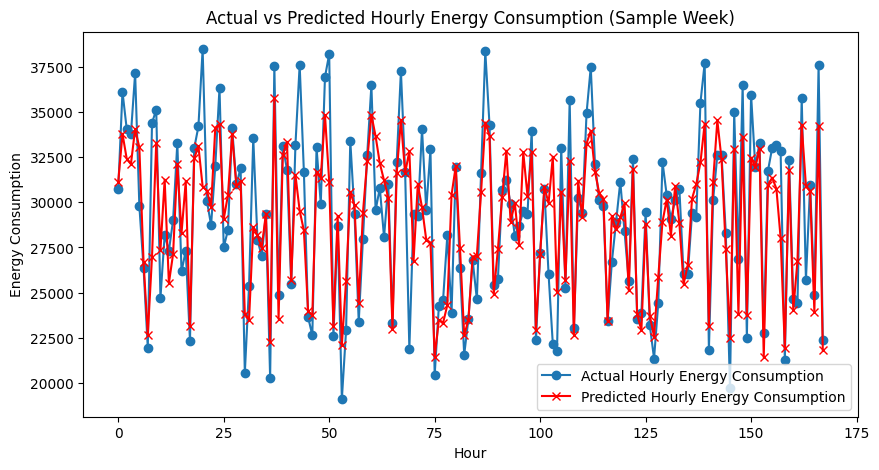

<ipython-input-5-64d3e8441dcc>:49: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=merged_df['time'].max(), periods=8760, freq='H')


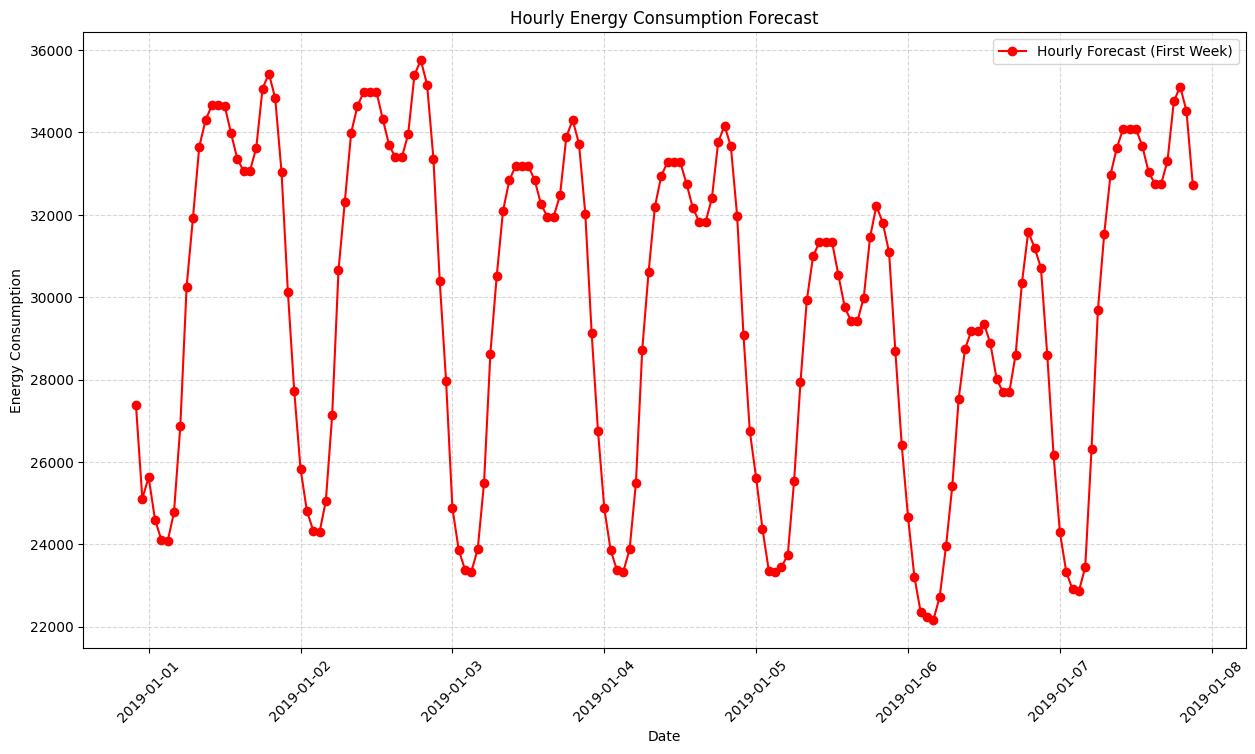

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

features = ['temp', 'wind_speed', 'humidity', 'pressure', 'hour', 'day_of_week', 'month', 'weather_cluster', 'clouds_all']
target = 'total load actual'

X = XGBOOST_data[features]
y = XGBOOST_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')
print(f'MAPE: {mape}%')

plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:168], label='Actual Hourly Energy Consumption', marker='o')
plt.plot(y_pred[:168], label='Predicted Hourly Energy Consumption', marker='x', color='red')
plt.legend()
plt.xlabel('Hour')
plt.ylabel('Energy Consumption')
plt.title('Actual vs Predicted Hourly Energy Consumption (Sample Week)')
plt.show()

# Forecast for 8760 Hours (365 Days)
date_range = pd.date_range(start=merged_df['time'].max(), periods=8760, freq='H')

future_df = pd.DataFrame()
future_df['time'] = date_range
future_df['hour'] = future_df['time'].dt.hour
future_df['day_of_week'] = future_df['time'].dt.dayofweek
future_df['month'] = future_df['time'].dt.month
future_df['year'] = future_df['time'].dt.year

future_df['temp'] = XGBOOST_data['temp'].iloc[-1]
future_df['wind_speed'] = XGBOOST_data['wind_speed'].iloc[-1]
future_df['humidity'] = XGBOOST_data['humidity'].iloc[-1]
future_df['pressure'] = XGBOOST_data['pressure'].iloc[-1]
future_df['weather_cluster'] = XGBOOST_data['weather_cluster'].iloc[-1]
future_df['clouds_all'] = XGBOOST_data['clouds_all'].iloc[-1]

future_X = future_df[features]
future_predictions = xgboost_model.predict(future_X)

future_df['predicted_energy_consumption'] = future_predictions
future_df.to_excel('future_hourly_energy_forecast.xlsx', index=False)

plt.figure(figsize=(15, 8))
plt.plot(date_range[:168], future_predictions[:168], color='red', linestyle='-', linewidth=1.5, marker='o', label='Hourly Forecast (First Week)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Hourly Energy Consumption Forecast')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

           Feature  Importance
4             hour    0.752076
5      day_of_week    0.106405
6            month    0.051252
0             temp    0.022213
3         pressure    0.019724
8       clouds_all    0.014054
7  weather_cluster    0.013796
2         humidity    0.011418
1       wind_speed    0.009062


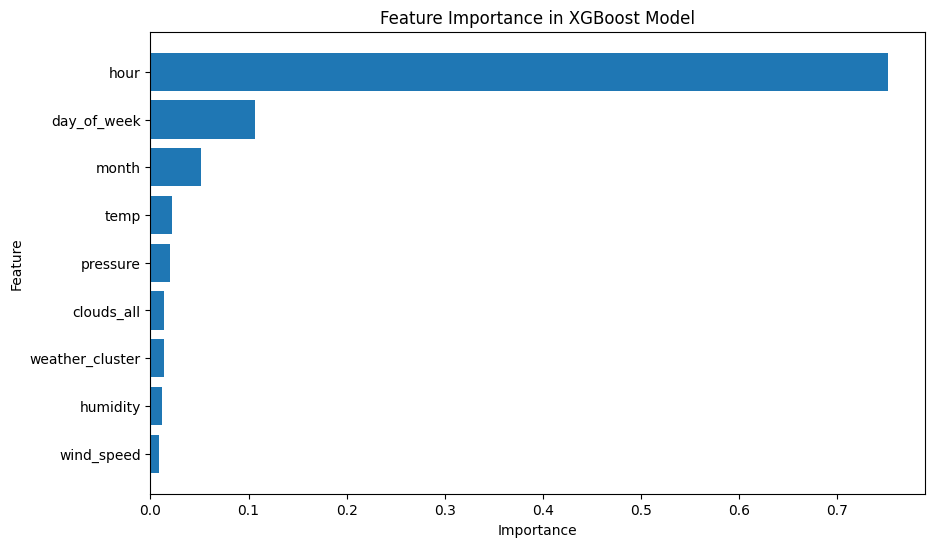

In [ ]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost Model')
plt.show()

      Feature  Importance
4        hour    0.924315
0        temp    0.030886
3    pressure    0.017436
2    humidity    0.015168
1  wind_speed    0.012196


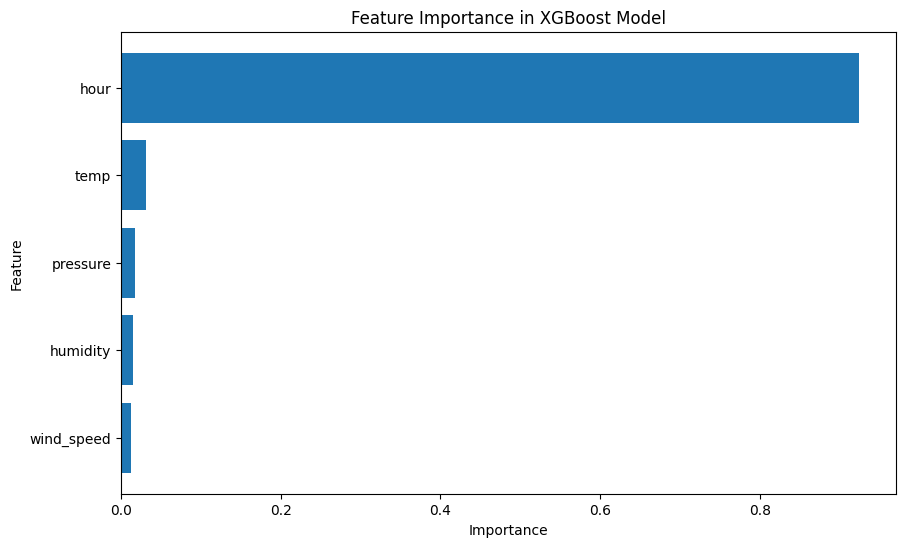

In [ ]:
X_train_filtered = X_train.drop(columns=['day_of_week', 'month','weather_cluster','clouds_all'])

model = xgb.XGBRegressor()
model.fit(X_train_filtered, y_train)

importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train_filtered.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost Model')
plt.show()